# Introduction

### 1. Defining the problem

**The first step in the Chollet Deep Learning work flow is to define the problem, this is to understand what your data is and what type of problem does it present?**

My data is from a classic cat vs dog dataset, where the goal is to make a model that can tell apart a cat from a dog. Learning how to solve this problem is a very much in line with deep learning as at its core being able to mimic human tasks that humans can do with ease is the goal of this field of study.

The problem proposed is a classic binary classification problem that deals with colour images. A quick look at a few sample pictures tells me that the data is quite comprehensive with 23,362 images of dogs and cats, and these pictures have dogs and cats of different breeds, at different stages of life (for examples - kittens vs elderly cat) & at varying amounts in a picture (one cat vs litter of kittens).

> <b>Possible Problem: Data Quantity </b>
    <p>Despite this data set being big, one proposed issue might be that due to the depth of the images, there might not be enough of each variant of images, for example a little of cats, to train the model as such this might corrupt the data. It is impossible to parse through all the data as such no way to confirm is this will or will not affect the data. </p>

> <b>Going forward:</b>
    <p>Most humans are able to differentiate a cat and a dog regardless of breed colour, stage of life or quantity, as such there is no need to change any classifications for human understanding as it is. We will have to dive deeper into the data and look at imbalances and then convert the data in to something that can train a DL model. </p> 
        
> <b>Hypothesis: </b>
    <p>My hypothesis is that the data, if processed and managed properly, can be informative to learn the relationship with between the inputs and outputs with a competent enough model after sufficient training, and as such can also be used to predict the correct binary classification of either cats or dogs on unseen data.</p>
   
       

### 2. Choosing measure of success

**The second step in the Chollet Deep Learning work flow is to choose a measure of success**

As proposed by Chollet himself, binary-classification problems where every class is equally likely would benefit from measures of success:

- Accuracy
- Precision
- Recall
- Area Under Curve

### 3. Deciding on an evaluation protocol

**The third step in the Chollet Deep Learning work flow is to decide on an evaluation protocol**

As this dataset is quite big maintaining a holdout validation seems to be the best choice, however I can always make changes to my validation techinique if the method does not work and using k-fold validation is also a good idea as well. 

# Code

### 4. Data preprocessing

**The fourth step in the Chollet Deep Learning work flow is data preprocessing**

In [1]:
!pip install --upgrade tensorflow
!pip install tensorflow-datasets

In [2]:
#import dependencies

import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from skimage.color import rgb2gray
from skimage.transform import resize

import tensorflow as tf
import tensorflow_datasets as tfds
from keras.utils import np_utils
from tensorflow.keras import models,layers
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop

import itertools
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

In [3]:
#load dataset
CDdataset = 'cats_vs_dogs'
resize_value = (32, 32, 3)
grey_scale = True

#generate randomseed
seed = 204
tf.random.set_seed(seed)
np.random.seed(seed)

ds = tfds.load(CDdataset, split='all', shuffle_files=True)

images = []
labels = []
for data in ds.take(len(ds)) : 
    image, label = data['image'], data['label']
    image, label = image.numpy(), label.numpy() #convert tensor into numpy.ndarray
    image = resize(image, resize_value, anti_aliasing=True)
    image = rgb2gray(image) #convert to greyscale     
    images.append(image)
    labels.append(label)

*Comments:* 
1. Shuffling of files is okay as this is a non-ordered dataset & is a good practise when dealing with classification problems.
2. Anti_aliasing is a good way to reduce the sharp edges of pixelated images and will allow for better training for the model as data is less extreme and more general
3. Image is converted to greyscale to reduce computational load as there is only 1 channel rather than 3. Although this would mean a loss in detail but the our images are not reliant on colour as a distinct feature, as such this step is wise.

In [4]:
#check images, labels data type
x = images
y = labels

print(type(x), type(y))


<class 'list'> <class 'list'>


In [5]:
#convert list of images to ndarray
x = np.array(images)

#flatten 2D image array to 1D array
x = x.reshape((x.shape[0], -1))

#convert list to ndarray
y = np.array(labels)


In [6]:
#count number of elements belonging to a class
np.bincount(y)

array([11658, 11604], dtype=int64)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, stratify=y, random_state=seed, shuffle=True) 

# normalise pixels from [0, 255] to [0, 1]
x_train, x_test = x_train/255, x_test/255

*Comments:* 
1. Stratify by y as we have binary classes, this will smoothen out any imbalances, albeit minor, when splitting training and test data.
2. Train-Validation-Test Split at 80/10/10.
3. Normalise pixels to [0,1] as gradient descent works better with homogenous constrained data

In [8]:
#make validation set

val_size = x_test.shape[0]
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_size, stratify=y_train, random_state = seed, shuffle=True)

### 5. Developing a model that does better than baseline

**The fifth step in the Chollet workflow is to develop a model that does better than baseline.**

Hypothetically, a common sense baseline model for a binary classification problem is one that has 50% of efficacy rate if the elements under each label are equivalent and the model has trains under both labels the same number of times.

As we stratify both cat and dog images(despite there being a slight imbalance) in the train_test_split function to train the model equally meaning that at a minimum they should be able to get this right 50% of the time.

In [9]:
#count number of samples per class
np.bincount(y)

array([11658, 11604], dtype=int64)

In [10]:
#count percentage
percentage = {np.sum(y == i)/y.shape[0]*100 for i in y}
print(percentage)

{49.88393087438741, 50.11606912561258}


In [11]:
balanced_y = balanced_accuracy_score(y_train, np.ones(len(y_train)))
print(balanced_y)

0.5


In [12]:
#function to a make model
def make_model(hidden_layers=0, hidden_neurons=np.nan, activation=None,dropout=np.nan, input_dimension=2, output_dimension=1, optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'], name = None) :
    
    model = models.Sequential()
    for layer in range(hidden_layers) :
        model.add(Dense(hidden_neurons, 
                  activation=activation, 
                  input_shape='default' if layer > 1 else (input_dimension,)))
        if np.isnan(dropout) == False:
            model.add(Dropout(dropout))
        
    model.add(Dense(output_dimension, 
                    activation='sigmoid' if output_dimension==1 else 'softmax',
                    input_shape='default' if hidden_layers>0 else (input_dimension,)))
  
    if name is not None :
        model._name = name
        
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model



*Comments:*

The above function returns a model based on the input parameters that define 
1. How many hidden layers does this model have
2. How many neurons are in these hidden layers
3. What is the activation function
4. What is the dropout rate

This model then returns a working model to be trained.

In [13]:
#function to train model
def train_model(model, x, y, class_weights,batch_size=32, epochs=100, val_data=None, callbacks=[], seed=0) :
    
    if val_data is None :
        x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, 
                                                          random_state=seed, shuffle=True, 
                                                          stratify=y)
        
    else :
        x_train, y_train, x_val, y_val = x, y, val_data[0], val_data[1]
  

    history = model.fit(x_train, y_train,
                        class_weight=class_weights,
                        batch_size=batch_size, epochs=epochs, 
                        validation_data=(x_val, y_val),
                        callbacks=callbacks,
                        verbose=0)

    return {'model': model, 
            'val_score': model.evaluate(x_val, y_val, verbose=0)[1:], 
            'history': history }

*Comments:*

The above function trains the model according to the training set while taking into account the class weight, the batch size, the validation data and a custom callback.

This model then returns a trained model, an evaluation score and the history object.

In [14]:
input_dimension = x_train.shape[1]
output_dimension = 1

optimizer = 'RMSprop'
loss_func = 'binary_crossentropy'
metrics = ['accuracy', 
           tf.keras.metrics.Precision(name='precision'), 
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc')]

print(input_dimension)

1024


*Comments:*

1. The primary loss function we are using are binary crossentropy as this is a binary classification problem.
2. The 4 metrics we are using are accuracy, precision,recall and area under curve.

In [15]:
#develop single layer pereceptron 
slp_model = make_model(hidden_layers=0, hidden_neurons=64,
                                activation='relu',
                                input_dimension=input_dimension, output_dimension=output_dimension,
                                optimizer=RMSprop(learning_rate=0.005), 
                                loss=loss_func, metrics=metrics,
                                name='Single_Layer_Perceptron')

slp_model.summary()

Model: "Single_Layer_Perceptron"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 1025      
                                                                 
Total params: 1,025
Trainable params: 1,025
Non-trainable params: 0
_________________________________________________________________


*Comments:*

1. A single layer perceptron is the simplest type of artificial neural networks and can only classify linearly separable cases with a binary target (1 , 0).

In [16]:
#define custom callback
early_stopping = EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=10, verbose=1)
type(early_stopping)

keras.callbacks.EarlyStopping

In [17]:
#compute weights in dict
weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))

class_weights

{0: 0.9976410036457216, 1: 1.002370178840767}

In [18]:
#train model and print 
trained_slp_model = train_model(slp_model, x_train, y_train,
                                              class_weights=class_weights,
                                              batch_size=128, epochs=500, 
                                              val_data=(x_val, y_val), 
                                              callbacks=[early_stopping], seed=seed)

print('Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(trained_slp_model['val_score'][0], balanced_y))
print('Precision (Validation): {:.2f}'.format(trained_slp_model['val_score'][1]))
print('Recall (Validation): {:.2f}'.format(trained_slp_model['val_score'][2]))
print('Area Under Curve (Validation): {:.2f}'.format(trained_slp_model['val_score'][3]))

print(trained_slp_model)

Restoring model weights from the end of the best epoch: 373.
Epoch 383: early stopping
Accuracy (Validation): 0.57 (baseline=0.50)
Precision (Validation): 0.57
Recall (Validation): 0.56
Area Under Curve (Validation): 0.59
{'model': <keras.engine.sequential.Sequential object at 0x000001775D872A60>, 'val_score': [0.5659647583961487, 0.5654813647270203, 0.5615848302841187, 0.591555118560791], 'history': <keras.callbacks.History object at 0x000001775EC5BCD0>}


In [19]:
preds = trained_slp_model['model'].predict(x_val)

print('Balanced Accuracy (Validation): {} (baseline={:.2f})'.format(balanced_accuracy_score(y_val, (preds > 0.5).astype('int32')), balanced_y))

73/73 [==============================] - 0s 388us/step
Balanced Accuracy (Validation): 0.5659553705845939 (baseline=0.50)


*Comments*

1. As we can see the accuracy for the validation beats that of the baseline at 57% vs 50%.
2. Even after balancing the predictions, we still return a value of 0.57.

In [20]:
#function to plot history
def plot_training_history(history, monitors=['loss', 'AUC']) :

  # using the variable axs for multiple Axes
  fig, axs = plt.subplots(1, 2, sharex='all', figsize=(30,10))
 
  for ax, monitor in zip(axs.flat, monitors) :
    loss, val_loss = history.history[monitor], history.history['val_' + monitor]

    if monitor == 'loss' :
          monitor = monitor.capitalize()

    epochs = range(1, len(loss)+1)

    ax.plot(epochs, loss, 'b.', label=monitor)
    ax.plot(epochs, val_loss, 'r.', label='Validation ' + monitor)
    ax.set_xlim([0, len(loss)])
    ax.title.set_text('Training and Validation ' + monitor + 's')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(monitor)
    ax.legend()
    ax.grid()

  _ = plt.show()

*Comments:*

Using the history object returned from the make_model function we then make a function to read this object to then plot the training and validation losses and the training and validation area under curves.

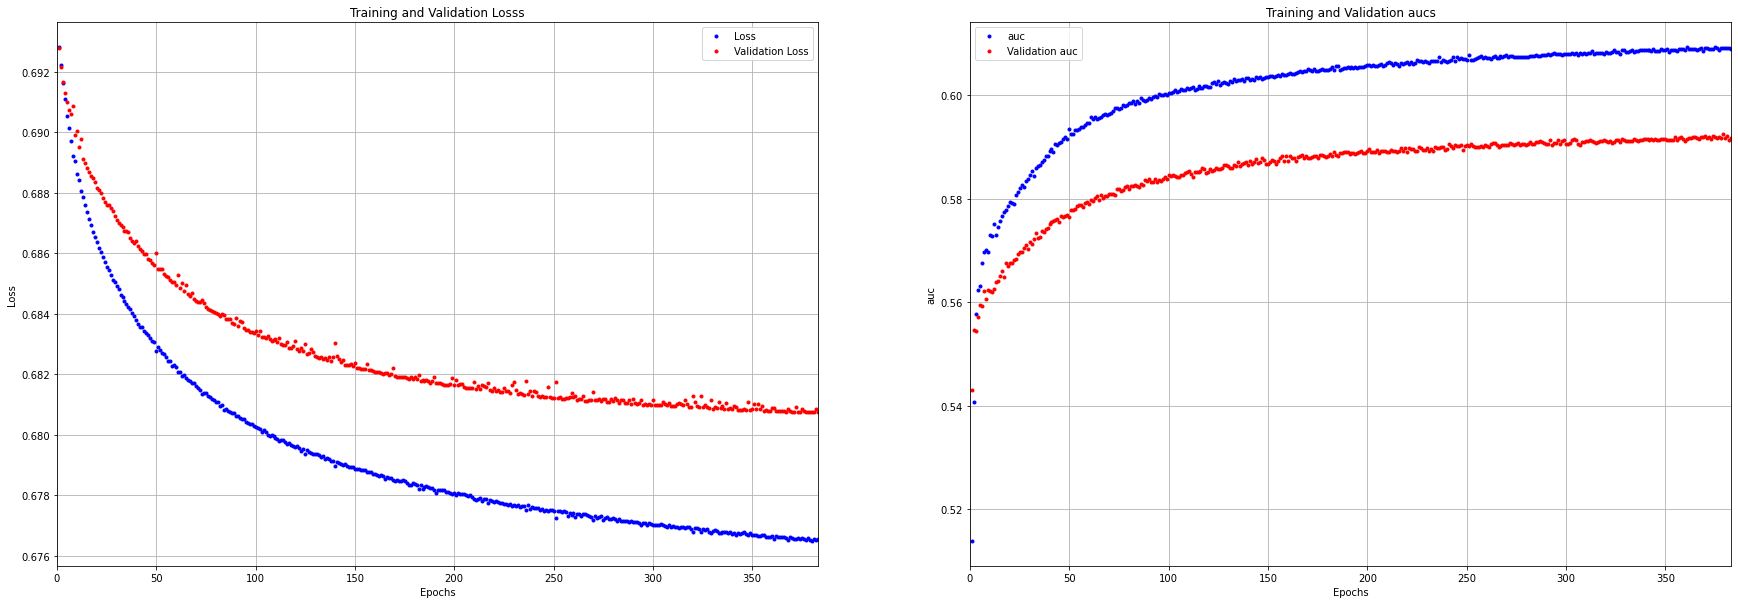

In [21]:
plot_training_history(trained_slp_model['history'], monitors=['loss', 'auc'])

*Comments*

Why did we choose to use Area Under Curve along with training and validation loss?


*   The Area Under the Curve (AUC) is often used as a measure of the ability of a binary classifier to distinguish between classes.
*   The higher the AUC, the better the model’s performance at distinguishing between the positive and negative classes.
*   When AUC = 1, the classifier can correctly distinguish between all the Positive and the Negative class points. 
*   When AUC = 0, then the classifier would predict all Negatives as Positives and all Positives as Negatives.
*   Generally speaking any score > 0.5 would be a good score.


What we see above is the pattern of an underfitting model as you can see the validation loss is greater than the training loss.

### 6. Scaling up: developing a model that overfits

**The sixth step in Chollet's Deep Learning workflow is to develop a model that overfits.**

In [22]:
#develop multi layer pereceptron model
mlp_model = make_model(hidden_layers=1, hidden_neurons=64,
                                activation='relu',
                                input_dimension=input_dimension, output_dimension=output_dimension,
                                optimizer=RMSprop(learning_rate=0.001), 
                                loss=loss_func, metrics=metrics,
                                name='Multi_Layer_Perceptron')

mlp_model.summary()

Model: "Multi_Layer_Perceptron"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 64)                65600     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 65,665
Trainable params: 65,665
Non-trainable params: 0
_________________________________________________________________


In [23]:
trained_mlp_model = train_model(mlp_model, x_train, y_train,
                                              class_weights=class_weights,
                                              batch_size=128, epochs=500, 
                                              val_data=(x_val, y_val), 
                                              callbacks=[], seed=seed)


*Comments:*

What is a multilayer perceptron?

- A Multilayer Perceptron is a network that can map non linear inputs and outputs.
- It has input and output layers, and one or more hidden layers with many neurons stacked together. 
- It is the big brother of the single layer perceptron.
- It can use any arbitrary activation function.

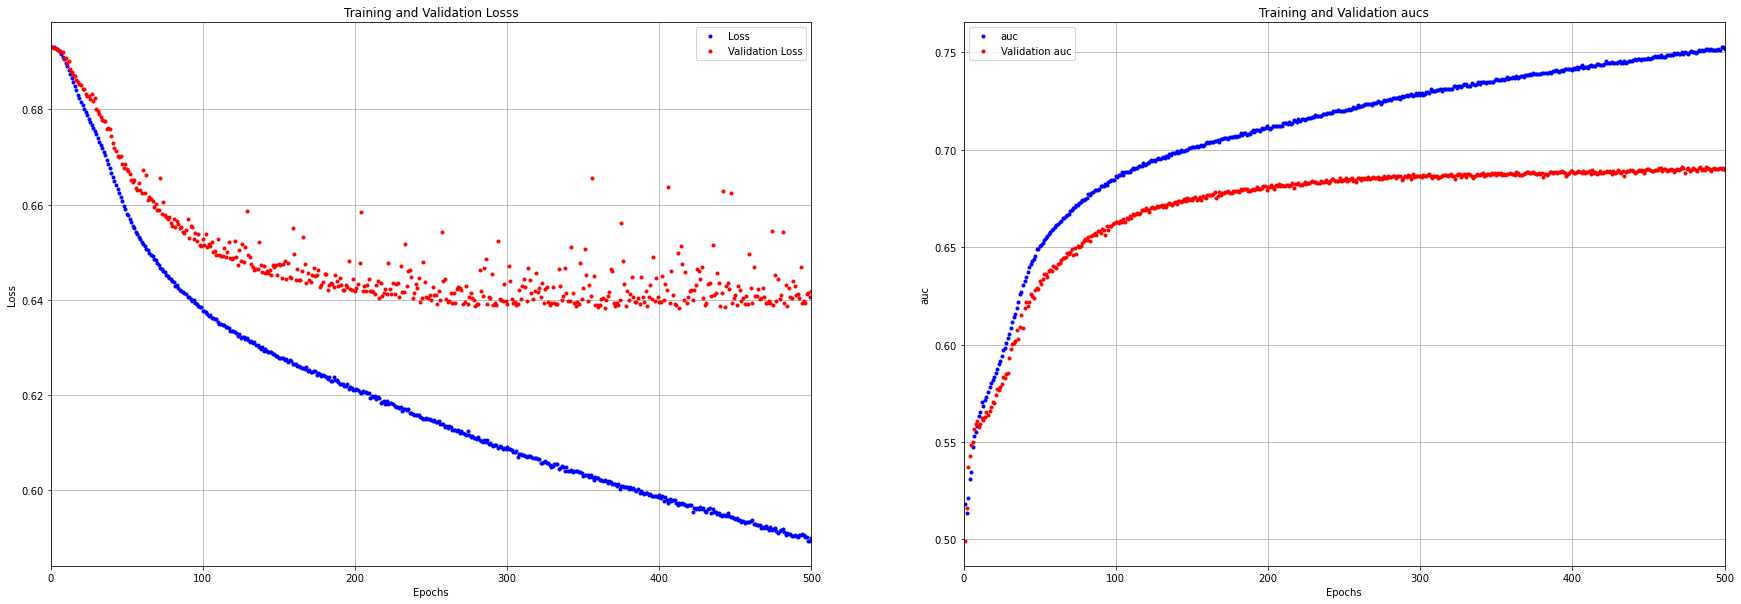

In [24]:
plot_training_history(trained_mlp_model['history'], monitors=['loss', 'auc'])

In [25]:
print('Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(trained_mlp_model['val_score'][0], balanced_y))
print('Precision (Validation): {:.2f}'.format(trained_mlp_model['val_score'][1]))
print('Recall (Validation): {:.2f}'.format(trained_mlp_model['val_score'][2]))
print('AUC (Validation): {:.2f}'.format(trained_mlp_model['val_score'][3]))

Accuracy (Validation): 0.64 (baseline=0.50)
Precision (Validation): 0.62
Recall (Validation): 0.73
AUC (Validation): 0.69


*Comments:*

What we are seeing above is an example of overfitting. Despite the better accuracy scores compared to the underfitting model, one can see the validation loss curve shows a lot of variance where it appears to be getting better but then slowly regresses again.

This is a result of the model being not generalised enough.

### 7. Regularizing your model and tuning your hyperparameters

**The final step in Chollet's Deep Learning workflow is to develop a model that fitss optimally by finetuning the parameters.**

By using the keras tuner, we are going to search for the best hyperparameters to be used to make the model. We will then compare the results to the previous metrics.

In [26]:
!pip install -q -U keras-tuner
import keras_tuner as kt

In [27]:
# make optimal model function
def make_opt_model(hp):
    model = models.Sequential()
    
    hp_activation = hp.Choice('activation', values=['relu', 'tanh','sigmoid', 'softmax'])
    hp_layer_1 = hp.Int('layer_1', min_value=1, max_value=1000, step=100)
    hp_layer_2 = hp.Int('layer_2', min_value=1, max_value=1000, step=100)
    hp_learning_rate = hp.Choice('learning_rate', values= list(np.arange(0.001,0.01, 0.001)))

    model.add(tf.keras.layers.Dense(units=hp_layer_1, activation=hp_activation))
    model.add(tf.keras.layers.Dense(units=hp_layer_2, activation=hp_activation))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer=RMSprop(learning_rate=hp_learning_rate),
                loss=loss_func,
            metrics=metrics)

    return model


In [28]:
tuner = kt.Hyperband(make_opt_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     overwrite=True,
                     factor=3,
                     directory='dir',
                     project_name='x')

In [29]:
tuner.search(x_train, y_train, epochs=500, validation_split=0.2, callbacks=[early_stopping])

Trial 30 Complete [00h 00m 23s]
val_accuracy: 0.5005373358726501

Best val_accuracy So Far: 0.5816765427589417
Total elapsed time: 00h 04m 33s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [30]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps)

In [31]:
tuner_model = tuner.hypermodel.build(best_hps)
tuner_history = tuner_model.fit(x_train, y_train, epochs=500, validation_split=0.1,
                    callbacks=[],verbose=0)

In [32]:
tuner_val_score = tuner_model.evaluate(x_val, y_val, verbose=0)
print('Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(tuner_val_score[0], balanced_y))
print('Precision (Validation): {:.2f}'.format(tuner_val_score[1]))
print('Recall (Validation): {:.2f}'.format(tuner_val_score[2]))
print('AUC (Validation): {:.2f}'.format(tuner_val_score[3]))

Accuracy (Validation): 0.70 (baseline=0.50)
Precision (Validation): 0.61
Recall (Validation): 0.60
AUC (Validation): 0.65


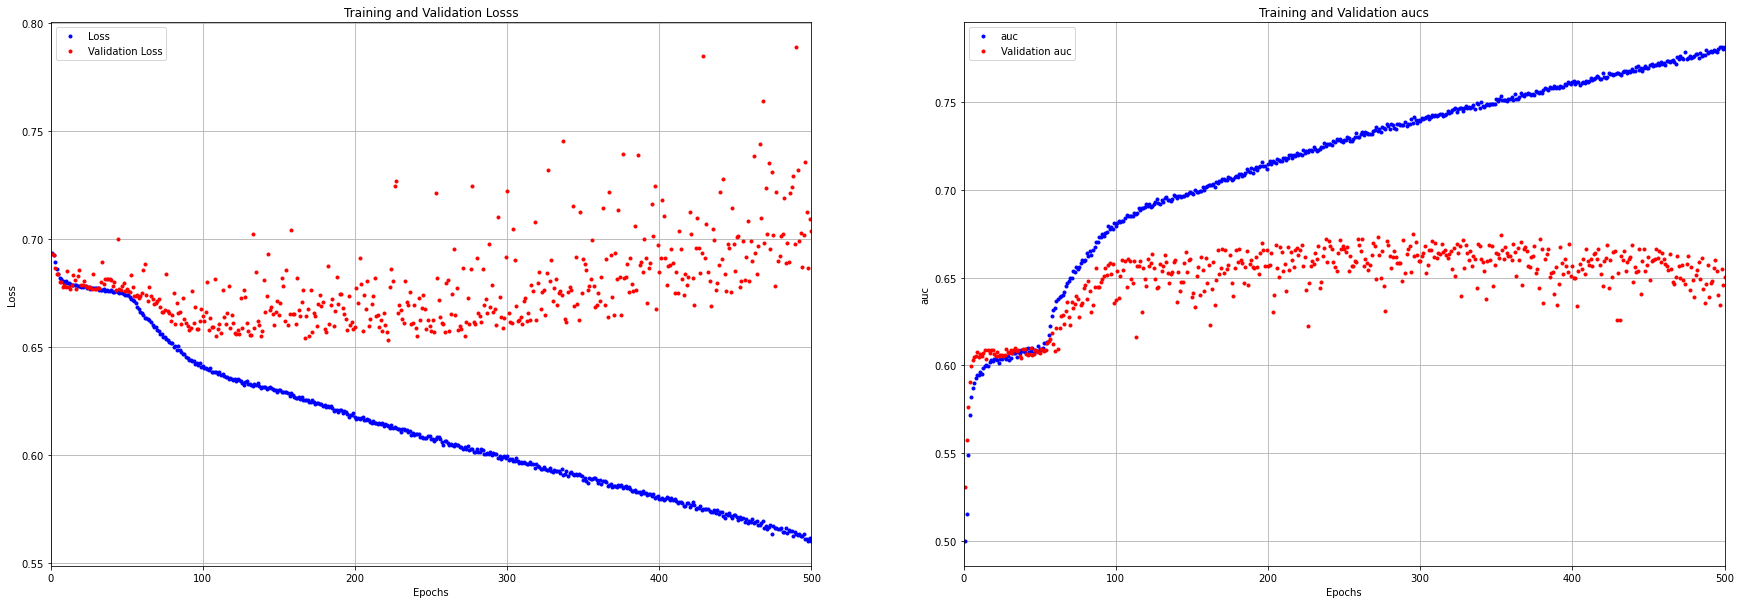

In [33]:
plot_training_history(tuner_history, monitors=['loss', 'auc'])

<i>Comments:</i>

As you can see from the above graphs, the tuning did not work as well as intented and the model started overfitting even more so than the previous intentionally overfit model.

As such, we are going to use a new method to try and make a better hyperparameter tuner.

<b>GridSearchCV</b>

In [34]:
# Reformat Grid CV Stats to Dataframe
def to_dataframe(stats, mapping) :
    entries = []
    for param, metrics in stats.items() :
        entry = eval(param)
        for key, value in metrics.items() :
            entry[key] = value
        
        for key, value in mapping.items() :
            entry[value] = entry['scores'][key]
            
        entry.pop('scores') 
        
        entries.append( entry )

    return pd.DataFrame(data=entries)

In [35]:
# Grid Search CV function
def grid_search_cv(X, y, class_weights,
                   space, cv, 
                   learning_rate, loss, metrics, 
                   epochs, callbacks=[], seed=0, 
                   order={}) :
    
    keys, values = zip(*space.items())
    
    stats = {}
    for params in [dict(zip(keys, v)) for v in itertools.product(*values)] :
        kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=seed)
        
        scores, stopped, losses = [], [], []
        for train, validate in kfold.split(X, y) :
            model = make_model(hidden_layers=params['hidden_layers'], 
                                        hidden_neurons=params['neurons'], 
                                        activation=params['activation'], 
                                        dropout=params['dropout'], 
                                        input_dimension=X.shape[1], 
                                        output_dimension=1 if len(y.shape)<2 else y.shape[1],
                                        optimizer=RMSprop(learning_rate=learning_rate), 
                                        loss=loss, metrics=metrics)
      
            trained = train_model(model,X[train,:], y[train],class_weights=class_weights,batch_size=params['batch_size'], epochs=epochs,  val_data=(X[validate,:], y[validate]), callbacks=callbacks, seed=seed) 
            
            evaluations = trained['model'].evaluate(X[validate,:], y[validate], verbose=0)[1:]
                        
            scores.append( evaluations )
            stopped.append( len(trained['history'].history['val_loss']) )
            losses.append( np.min(trained['history'].history['val_loss']) )
        
        stats[str(params)] = { 'scores': np.mean(scores, axis=0), 
                               'epochs': np.mean(stopped), 
                               'val_loss': np.mean(losses) }
    
    return to_dataframe(stats, order)

In [36]:
orders = {
    0: 'accuracy',              
    1: 'precision',
    2: 'recall',
    3: 'auc',
}

KFOLDS = 5

params = {
    'hidden_layers': [1, 2],
    'neurons': [64],
    'activation': ['relu'],
    'dropout': [0.2],
    'batch_size': [128]
}


stats = grid_search_cv(x_train, y_train,  
                       class_weights=class_weights,
                       space=params, cv=KFOLDS, 
                       learning_rate=0.001, 
                       loss=loss_func, metrics=metrics, 
                       epochs=1000, callbacks=[early_stopping], seed=seed,
                       order=orders)

Restoring model weights from the end of the best epoch: 171.
Epoch 181: early stopping
Restoring model weights from the end of the best epoch: 184.
Epoch 194: early stopping
Restoring model weights from the end of the best epoch: 175.
Epoch 185: early stopping
Restoring model weights from the end of the best epoch: 135.
Epoch 145: early stopping
Restoring model weights from the end of the best epoch: 192.
Epoch 202: early stopping
Restoring model weights from the end of the best epoch: 71.
Epoch 81: early stopping
Restoring model weights from the end of the best epoch: 102.
Epoch 112: early stopping
Restoring model weights from the end of the best epoch: 59.
Epoch 69: early stopping
Restoring model weights from the end of the best epoch: 53.
Epoch 63: early stopping
Restoring model weights from the end of the best epoch: 65.
Epoch 75: early stopping


In [37]:
stats.sort_values(by=['auc'], ascending=False)

,hidden_layers,neurons,activation,dropout,batch_size,epochs,val_loss,accuracy,precision,recall,auc
1,2,64,relu,0.2,128,80.0,0.644706,0.626343,0.614268,0.674637,0.673132
0,1,64,relu,0.2,128,181.4,0.646161,0.624033,0.610883,0.678624,0.671915


In [38]:
opt_model = make_model(hidden_layers=1, hidden_neurons=64,
                                dropout=0.2, activation='relu',
                                input_dimension=input_dimension, output_dimension=output_dimension,
                                optimizer=RMSprop(learning_rate=0.0025), 
                                loss=loss_func, metrics=metrics,
                                name='Best_Network')

opt_model.summary()

Model: "Best_Network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_31 (Dense)            (None, 64)                65600     
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 dense_32 (Dense)            (None, 1)                 65        
                                                                 
Total params: 65,665
Trainable params: 65,665
Non-trainable params: 0
_________________________________________________________________


In [39]:
trained_opt_model = train_model(opt_model, x_train, y_train,
                                              class_weights=class_weights,
                                              batch_size=128, epochs=500, 
                                              val_data=(x_val, y_val), 
                                              callbacks=[early_stopping], seed=seed)

Restoring model weights from the end of the best epoch: 146.
Epoch 156: early stopping


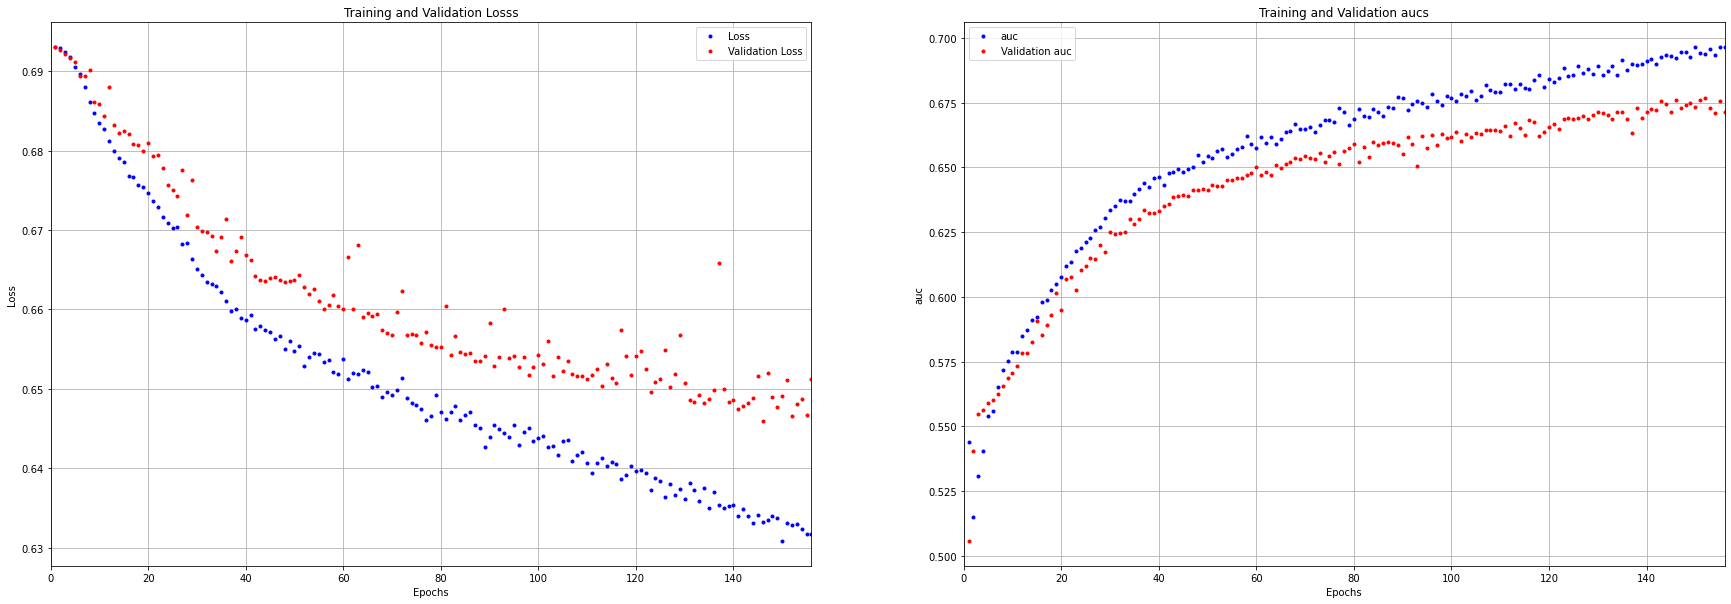

In [40]:
plot_training_history(trained_opt_model['history'], monitors=['loss', 'auc'])

In [41]:
print('Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(trained_opt_model['val_score'][0], balanced_y))
print('Precision (Validation): {:.2f}'.format(trained_opt_model['val_score'][1]))
print('Recall (Validation): {:.2f}'.format(trained_opt_model['val_score'][2]))
print('AUC (Validation): {:.2f}'.format(trained_opt_model['val_score'][3]))

Accuracy (Validation): 0.63 (baseline=0.50)
Precision (Validation): 0.61
Recall (Validation): 0.70
AUC (Validation): 0.68


In [42]:
preds = trained_opt_model['model'].predict(x_test, verbose=0)

print('Accuracy (Test): {:.2f} (baseline={:.2f})'.format(accuracy_score(y_test, (preds > 0.5).astype('int32')), balanced_y))
print('Precision (Test): {:.2f}'.format(precision_score(y_test, (preds > 0.5).astype('int32'))))
print('Recall (Test): {:.2f}'.format(recall_score(y_test, (preds > 0.5).astype('int32'))))
print('AUC (Test): {:.2f}'.format(roc_auc_score(y_test, preds)))

Accuracy (Test): 0.61 (baseline=0.50)
Precision (Test): 0.60
Recall (Test): 0.70
AUC (Test): 0.66


<i>Comments:</i>

So I decided to use a custom gridsearchCV algorithm to search for the best parameters. This algorithm calculates the mean of all epochs, scores and val losses to return the best hyperparameters. We then made an optimal model and the loss curves and area under curve charts are as seen above.

This validation loss curve does not stagnate like the overfitting model but also follows closer to the training loss curve as compared to the underfitting model

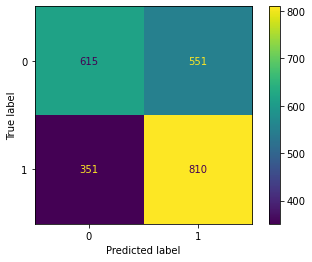

In [43]:
disp = ConfusionMatrixDisplay( confusion_matrix(y_test, (preds > 0.5).astype('int32')) )
disp.plot()

As seen in the confusion matrix above, the model can predict cats  better than it can dogs, in the sense that despite the correct guesses for dogs being higher(810 vs 615), there are relatively more wrongly classifications for dogs(551 vs 351). And since this is a binary classification, if it is not labeled one thing it is the other.

# Conclusion

In conclusion, I do believe that my final model works generally well. Although the results are skewed in the favour of cats, I do think that given more data to work with and more computational power, we will be able to fine tune this model even more.

As I mentioned earlier, any model that has > 0.5 AUC score is considered to have a good binary classifier model.